Kd Analysis
===

In [1]:
####################################################################################
#                                                                                  #
# Leave these values blank to let the script determine them automatically.         #
# Only set them if something goes wrong!                                           #
#                                                                                  #
####################################################################################
chip_id = ''
target_name = 'DNMT1_site3_23'
neg_control_target_name = ''
all_channels = []
data_channel = ''
target_sequence_file = "/shared/targets.yml"
nonneg_lda_weights_fpath = '/shared/yeast_beast_LDA_weights.txt'  # for microscope 3
# nonneg_lda_weights_fpath = '/shared/bLDA_coef_nonneg.txt'  # for microscope 2 and 4

In [2]:
import glob
import re
import yaml
from champ import initialize

def determine_chip_id(override_value):
    # let the user override this method with a manually-specified value
    if override_value:
        return override_value
    
    chip_regex = re.compile(r'.*?(SA\d{5}).*?')
    filenames = glob.glob('*')
    candidates = set()
    
    # look through all the filenames in this directory and look for anything that looks like a sequencing run ID, which we use as chip IDs
    for filename in filenames:
        match = chip_regex.search(filename)
        if match:
            candidates.add(match.group(1))
    # there should be a unique value unless someone had an unfortunate choice of filenames
    if len(candidates) == 1:
        return list(candidates)[0]
    raise ValueError("We were unable to automatically determine the chip ID based on filenames, you'll need to set it manually.")


def load_config_value(item_name, override_value):
    # let the user override this method with a manually-specified value
    if override_value:
        return override_value
    try:
        with open("champ.yml") as f:
            config = yaml.load(f)
            return config[item_name]
    except Exception as e:
        print(e)
        raise ValueError("We could not determine the {item_name} from champ.yml. Make sure you have a configuration file and that the value is set.".format(item_name=item_name))

        
def determine_data_channel(all_channels, alignment_channel):
    alignment_channel = set([alignment_channel])
    all_channels = set(map(str, all_channels))
    data_channel = all_channels - alignment_channel
    if len(data_channel) == 1:
        # There are two channels, so we return the one that isn't the alignment channel
        return list(data_channel)[0]
    if not data_channel:
        # There is only one channel, so alignment markers and data are in the same channel
        return list(alignment_channel)[0]
    raise ValueError("Could not determine data channel. You'll need to set this manually.")

In [3]:
chip_id = determine_chip_id(chip_id)
target_name = load_config_value('perfect_target_name', target_name)
neg_control_target_name = load_config_value('neg_control_target_name', neg_control_target_name)
all_channels = list(map(str, initialize.determine_channel_names('.'))) if not all_channels else all_channels
alignment_channel = load_config_value('alignment_channel', data_channel)
data_channel = determine_data_channel(all_channels, alignment_channel)

In [4]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [5]:
import os
import sys
import glob
import numpy as np
import matplotlib.pyplot as plt
import random
import itertools
from collections import defaultdict, Counter
from IPython.display import HTML, Image
from champ import misc, intensity, initialize, seqtools, adapters_cython
import yaml

read_name_dir = os.path.join('/shared', chip_id, 'read_names')
read_names_by_seq_fpath = os.path.join(read_name_dir, 'read_names_by_seq.txt')
out_fname = 'LDA_intensity_scores.txt'

Run Specific Section
===

### Parameters

In [6]:
with open(target_sequence_file) as f:
    targets = yaml.load(f)

target = targets[target_name]
neg_control_target = targets[neg_control_target_name]
datadir = 'results'
figdir = 'figs'
for dpath in [figdir, datadir]:
    if not os.path.isdir(dpath):
        os.makedirs(dpath)
out_fpath = os.path.join(datadir, out_fname)

print 'Chip ID:', chip_id
print 'Target "{}":'.format(target_name), target
print 'Neg control target "{}":'.format(neg_control_target_name), neg_control_target
print 'Channels:', all_channels
print 'Protein channel:', data_channel
print 'Output file:', out_fpath

Chip ID: SA18014
Target "DNMT1_site3_23": TTTCCTGATGGTCCATGTCTGTTACTC
Neg control target "D": TTTAGTGATAAGTGGAATGCCATGTGG
Channels: ['Blue']
Protein channel: Blue
Output file: results/LDA_intensity_scores.txt


### Sequence of Interest Function

In [7]:
interesting_seqs = set()
    
stretch = set()
for i in range(1, len(target)+1):
    stretch.update(seqtools.get_stretch_of_complement_seqs(target, i))
insertions = set()
for i in range(1, 3):
    insertions.update(seqtools.get_contiguous_insertion_seqs(target, i))
for i in range(1, 3):
    insertions.update(seqtools.get_insertion_seqs(target, i))   
deletions = set()
for i in range(1, 3):
    deletions.update(seqtools.get_deletion_seqs(target, i))
mismatches = set()
for i in range(1, 3):
    mismatches.update(seqtools.get_mismatch_seqs(target, i))
six_n_pam = seqtools.get_randomized_pam_seqs(target, 4, 6)
other_targets = set()
for s in targets.values():
    other_targets.add(s)

interesting_seqs.update(other_targets)
interesting_seqs.update(stretch)
interesting_seqs.update(insertions)
interesting_seqs.update(deletions)
interesting_seqs.update(mismatches)
interesting_seqs.update(six_n_pam)

print("Interesting sequences: %d" % len(interesting_seqs))

Interesting sequences: 11374


# Create Interesting Sequences Files

For some reason, the `read_names_by_seq.txt` file often contains sequences with extra bases on either end of the sequence we actually care about. Which is to say, the reads are not being parsed properly. This wasn't happening before and I don't know what's changed. Regardless, here we go through it, and check every single sequence in that file to see if it contains a sequence of interest as a substring. This way, we generate a custom file that contains an exact mapping between read names and interesting sequences.

In [8]:
from champ.seqtools import build_interesting_sequences
interesting_read_names_filename = os.path.join(read_name_dir, 'interesting_{target_name}_reads_by_seq.txt'.format(target_name=target_name))
if os.path.exists(interesting_read_names_filename):
    # No need to recalculate, we can just load this from disk
    interesting_read_names = {}
    with open(interesting_read_names_filename) as f:
        for line in f:
            line = line.split("\t")
            sequence = line[0]
            read_names = line[1:]
            interesting_read_names[sequence] = read_names
else:
    interesting_read_names = build_interesting_sequences(read_names_by_seq_fpath, interesting_seqs)
    with open(interesting_read_names_filename, 'w') as f:
        for sequence, read_names in interesting_read_names.items():
            f.write("%s\t%s\n" % (sequence, "\t".join(read_names)))

In [9]:
# Decide how many insertions or deletions to allow
min_len = len(target) - 3
max_len = len(target) + 3
max_ham = 7

def is_interesting_seq(seq):
    if seq in interesting_seqs:
        return True

Load Data
===

In [10]:
all_read_name_fpath = os.path.join(read_name_dir, 'all_read_names.txt')
target_read_name_fpath = os.path.join(read_name_dir, 'target_dnmt1_site3_read_names.txt')
perfect_target_read_name_fpath = os.path.join(read_name_dir, 'perfect_target_dnmt1_site3_read_names.txt')
neg_control_target_read_name_fpath = os.path.join(read_name_dir, 'perfect_target_{}_read_names.txt'.format(neg_control_target_name.lower()))
phiX_read_name_fpath = os.path.join(read_name_dir, 'phix_read_names.txt')

all_read_names = set(line.strip() for line in open(all_read_name_fpath))
print("All read names: %d" % len(all_read_names))
target_read_names = set(line.strip() for line in open(target_read_name_fpath))
print("Target read names: %d" % len(target_read_names))
perfect_target_read_names = set(line.strip() for line in open(perfect_target_read_name_fpath))
print("Perfect target read names: %d" % len(perfect_target_read_names))
neg_control_target_read_names = set(line.strip() for line in open(neg_control_target_read_name_fpath))
print("Negative control read names: %d" % len(neg_control_target_read_names))
phiX_read_names = set(line.strip() for line in open(phiX_read_name_fpath))
print("Phix read names: %d" % len(phiX_read_names))

All read names: 9484718
Target read names: 1644479
Perfect target read names: 7098
Negative control read names: 9625
Phix read names: 1184160


In [11]:
h5_fpaths = glob.glob('*.h5')

h5_fpaths.sort(key=misc.parse_concentration)
for fpath in h5_fpaths:
    print misc.parse_concentration(fpath), fpath

1.0 20180220-SA18014-AsCas12aD908A-1pM_1.h5
500.0 20180220-SA18014-AsCas12aD908A-500pM_1.h5
1000.0 20180220-SA18014-AsCas12aD908A-1nM_1.h5
2000.0 20180220-SA18014-AsCas12aD908A-2nM_1.h5
4000.0 20180220-SA18014-AsCas12aD908A-4nM_1.h5
8000.0 20180220-SA18014-AsCas12aD908A-8nM_1.h5
16000.0 20180220-SA18014-AsCas12aD908A-16nM_1.h5
32000.0 20180220-SA18014-AsCas12aD908A-32nM_1.h5
64000.0 20180220-SA18014-AsCas12aD908A-64nM_1.h5
128000.0 20180220-SA18014-AsCas12aD908A-128nM_1.h5
256000.0 20180220-SA18014-AsCas12aD908A-256nM_1.h5
512000.0 20180220-SA18014-AsCas12aD908A-512nM_1.h5


In [12]:
results_dirs = [
    os.path.join('results', 
                 os.path.splitext(os.path.basename(h5_fpath))[0])
    for h5_fpath in h5_fpaths
]
for d in results_dirs:
    print(d)

results/20180220-SA18014-AsCas12aD908A-1pM_1
results/20180220-SA18014-AsCas12aD908A-500pM_1
results/20180220-SA18014-AsCas12aD908A-1nM_1
results/20180220-SA18014-AsCas12aD908A-2nM_1
results/20180220-SA18014-AsCas12aD908A-4nM_1
results/20180220-SA18014-AsCas12aD908A-8nM_1
results/20180220-SA18014-AsCas12aD908A-16nM_1
results/20180220-SA18014-AsCas12aD908A-32nM_1
results/20180220-SA18014-AsCas12aD908A-64nM_1
results/20180220-SA18014-AsCas12aD908A-128nM_1
results/20180220-SA18014-AsCas12aD908A-256nM_1
results/20180220-SA18014-AsCas12aD908A-512nM_1


In [13]:
print 'Loading data...'
int_scores = intensity.IntensityScores(h5_fpaths)
int_scores.get_LDA_scores(results_dirs, nonneg_lda_weights_fpath)

Loading data...
20180220-SA18014-AsCas12aD908A-1pM_1.h5
Num results files: 806
20180220-SA18014-AsCas12aD908A-500pM_1.h5
Num results files: 808
20180220-SA18014-AsCas12aD908A-1nM_1.h5
Num results files: 811
20180220-SA18014-AsCas12aD908A-2nM_1.h5
Num results files: 812
20180220-SA18014-AsCas12aD908A-4nM_1.h5
Num results files: 817
20180220-SA18014-AsCas12aD908A-8nM_1.h5
Num results files: 832
20180220-SA18014-AsCas12aD908A-16nM_1.h5
Num results files: 842
20180220-SA18014-AsCas12aD908A-32nM_1.h5
Num results files: 854
20180220-SA18014-AsCas12aD908A-64nM_1.h5
Num results files: 869
20180220-SA18014-AsCas12aD908A-128nM_1.h5
Num results files: 869
20180220-SA18014-AsCas12aD908A-256nM_1.h5
Num results files: 864
20180220-SA18014-AsCas12aD908A-512nM_1.h5
Num results files: 860


In [14]:
import time
print 'Normalizing data...'
int_scores.normalize_scores()
print 'Done normalizing.'

Normalizing data...
20180220-SA18014-AsCas12aD908A-1pM_1.h5

20180220-SA18014-AsCas12aD908A-500pM_1.h5

20180220-SA18014-AsCas12aD908A-1nM_1.h5

20180220-SA18014-AsCas12aD908A-2nM_1.h5

20180220-SA18014-AsCas12aD908A-4nM_1.h5

20180220-SA18014-AsCas12aD908A-8nM_1.h5

20180220-SA18014-AsCas12aD908A-16nM_1.h5

20180220-SA18014-AsCas12aD908A-32nM_1.h5

20180220-SA18014-AsCas12aD908A-64nM_1.h5

20180220-SA18014-AsCas12aD908A-128nM_1.h5

20180220-SA18014-AsCas12aD908A-256nM_1.h5

20180220-SA18014-AsCas12aD908A-512nM_1.h5

Done normalizing.


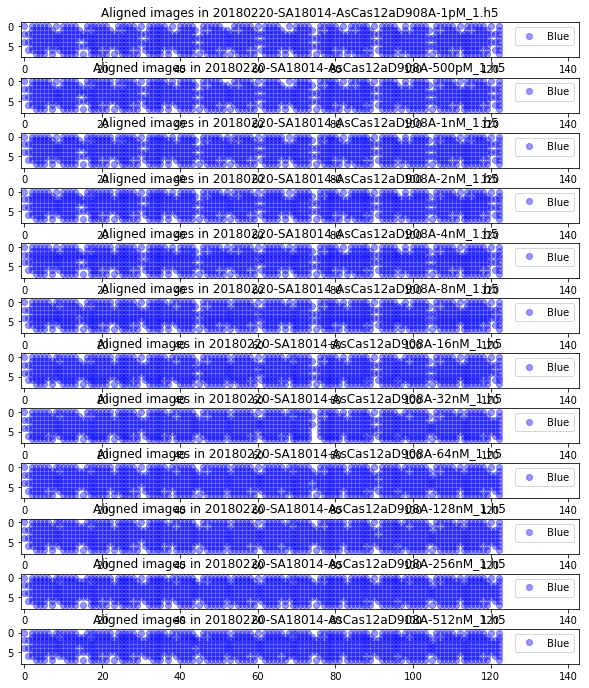

In [15]:
int_scores.plot_aligned_images('br', 'o*')

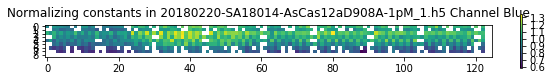

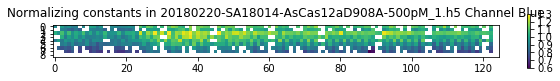

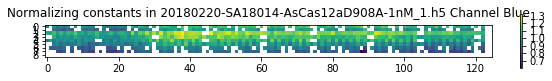

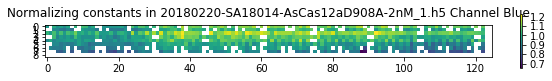

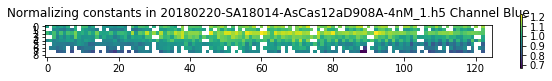

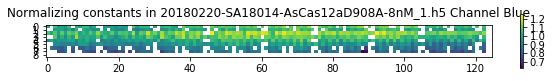

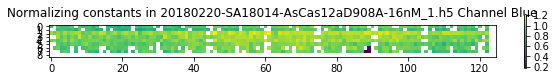

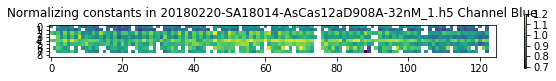

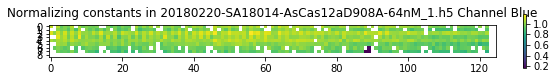

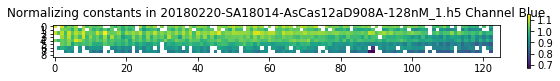

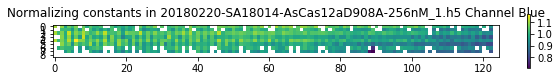

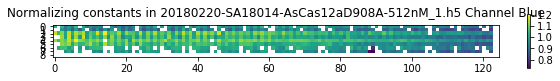

In [16]:
int_scores.plot_normalization_constants()

In [17]:
int_scores.print_reads_per_channel()

All reads found in channel Blue: 7,668,126


In [18]:
good_num_ims_cutoff = len(h5_fpaths) - 3
int_scores.build_good_read_names(good_num_ims_cutoff)

In [19]:
good_read_names = int_scores.good_read_names

In [20]:
good_perfect_read_names = perfect_target_read_names & good_read_names
print 'Good Reads:', len(good_read_names)
print 'Good Perfect Reads:', len(good_perfect_read_names)

Good Reads: 7179813
Good Perfect Reads: 5325


In [21]:
int_scores.build_score_given_read_name_given_channel()

20180220-SA18014-AsCas12aD908A-1pM_1.h5
20180220-SA18014-AsCas12aD908A-500pM_1.h5
20180220-SA18014-AsCas12aD908A-1nM_1.h5
20180220-SA18014-AsCas12aD908A-2nM_1.h5
20180220-SA18014-AsCas12aD908A-4nM_1.h5
20180220-SA18014-AsCas12aD908A-8nM_1.h5
20180220-SA18014-AsCas12aD908A-16nM_1.h5
20180220-SA18014-AsCas12aD908A-32nM_1.h5
20180220-SA18014-AsCas12aD908A-64nM_1.h5
20180220-SA18014-AsCas12aD908A-128nM_1.h5
20180220-SA18014-AsCas12aD908A-256nM_1.h5
20180220-SA18014-AsCas12aD908A-512nM_1.h5


Collating by Sequence
===

In [22]:
# Find only read names with cascade scores
print("Starting")
aligned_read_names = []
for h5_fpath in h5_fpaths:
    sys.stdout.write('.')
    sys.stdout.flush()
    for d in int_scores.scores[h5_fpath][data_channel].values():
        for read_name in d.keys():
            aligned_read_names.append(read_name)
aligned_read_names = set(aligned_read_names)
print '\nAligned reads in protein channel:', len(aligned_read_names)

Starting
............
Aligned reads in protein channel: 7668126


In [23]:
try:
    max_ham
except:
    max_ham = 7

In [24]:
print 'Collating Reads by Sequence'
interesting_reads = seqtools.build_read_names_given_seq(target,
                                                        interesting_read_names_filename,
                                                        aligned_read_names,
                                                        is_interesting_seq,
                                                        max_ham)

print(len(interesting_reads))

Collating Reads by Sequence
..12493


In [25]:
interesting_reads[neg_control_target].update(neg_control_target_read_names)

# Filter Reads

We filter reads with outlier intensities for their sequence identity, and filter sequences with fewer than 5 reads.

In [26]:
min_reads = 5
tukey_contant = 1.5  # Read acceptabale if in range [q1 - tukey_contant * iqr, q3 + tukey_contant * iqr]

In [27]:
print 'Filtering reads by intensity and seqs by final read count'
intensities = defaultdict(list)

for i, read_name in enumerate(all_read_names):
    if i % 10000 == 0:
        sys.stdout.write('.')
        sys.stdout.flush()
    for h5_fpath in h5_fpaths:
        if data_channel not in int_scores.score_given_read_name_in_channel[h5_fpath]:
            continue
        score = int_scores.score_given_read_name_in_channel[h5_fpath][data_channel].get(read_name)
        if score:
            intensities[read_name].append(score)
        else:
            intensities[read_name].append(None)

Filtering reads by intensity and seqs by final read count
..............................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [28]:
with open("results/read-name-intensities.txt", "w") as f:
    for read_name, intvals in intensities.items():
        ok_val_count = sum([1 for i in intvals if i is not None])
        if ok_val_count > 12:
            f.write("%s\t%s\n" % (read_name, "\t".join([str(i) for i in intvals])))

In [29]:
print("woo")

woo


In [30]:
print 'Filtering reads by intensity and seqs by final read count'
interesting_seqs = set()
for i, (seq, read_names) in enumerate(interesting_reads.items()):
    if i % 10000 == 0:
        sys.stdout.write('.')
        sys.stdout.flush()
    if len(read_names) < min_reads:
        continue
    for h5_fpath in h5_fpaths:
        if data_channel not in int_scores.score_given_read_name_in_channel[h5_fpath]:
            continue
        score_given_read_name = int_scores.score_given_read_name_in_channel[h5_fpath][data_channel]
        intensities = [
            score_given_read_name[read_name]
            for read_name in read_names
            if read_name in score_given_read_name
        ]
        if len(intensities) < min_reads:
            continue
        q1 = np.percentile(intensities, 25)
        q3 = np.percentile(intensities, 75)
        iqr = q3 - q1
        min_range, max_range = (q1 - tukey_contant * iqr, q3 + tukey_contant * iqr)
        new_read_names = set()
        for read_name in read_names:
            try:
                if min_range <= score_given_read_name[read_name] <= max_range:
                    new_read_names.add(read_name)
            except KeyError:
                pass
            
    interesting_reads[seq] = new_read_names
    if len(new_read_names) >= min_reads:
        interesting_seqs.add(seq)

Filtering reads by intensity and seqs by final read count
..

/mnt/marble/hdd/home/jim/champ/champ/seqtools.py:294: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.
  ax.set_axis_bgcolor('white')


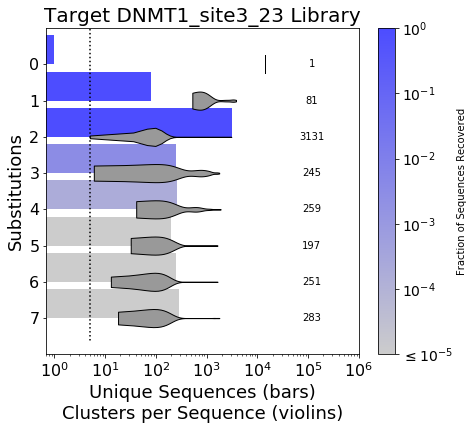

In [31]:
fig, ax = plt.subplots(figsize=(7, 6))
seqtools.plot_library_comp_by_hamming_distance(ax,
                                               target,
                                               max_ham,
                                               min_reads,
                                               interesting_reads,
                                               interesting_seqs)
ax.set_title('Target {} Library'.format(target_name), fontsize=20)

In [32]:
print 'Negative Control Seqs:', len(interesting_reads[neg_control_target])

Negative Control Seqs: 7303


# Write Output

In [33]:
concentrations = map(misc.parse_concentration, h5_fpaths)
print 'Concentrations:'
concentrations

Concentrations:


[1.0,
 500.0,
 1000.0,
 2000.0,
 4000.0,
 8000.0,
 16000.0,
 32000.0,
 64000.0,
 128000.0,
 256000.0,
 512000.0]

In [34]:
trait_name = 'concentration_pM'
trait_list = concentrations
attrs_dict = {
    'target': target, 
    'target_name': target_name,
    'neg_control_target': neg_control_target,
    'neg_control_target_name': neg_control_target_name,
}

int_scores.write_values_by_seq(
    course_trait_name=trait_name,
    course_trait_list=trait_list,
    h5_fpaths=h5_fpaths,
    attrs_dict=attrs_dict,
    channel_of_interest=data_channel,
    seqs_of_interest=interesting_seqs,
    read_names_given_seq=interesting_reads,
    out_fpath=out_fpath,       
)